# COVID-19: Exploratory Data Analysis.

In this notebook you will find a brief data anaylsis of the covid-19 cases in Switzerland.

After essential data analysis is performed an attempt at dfining and fitting a poisson regression model is done and using logistic regression on the percentage of the population is also proposed. After several trial the exponential terms in the poisson regression leads to numeric instability. Another notebook present another approach consisting in fitting well known growth model.

The dataset comes from: https://github.com/daenuprobst/covid19-cases-switzerland

In [78]:
# usual imports
from datetime import date, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.linear_model import PoissonRegressor
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Exploratory Data Analysis (EDA)

In [2]:
# retrieve the cases data from github
url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_cases_switzerland_openzh.csv"
covid19_cases = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
covid19_cases.head()

,AG,AI,AR,BE,BL,BS,FR,GE,GL,GR,...,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH,CH
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2020-02-27,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0
2020-02-28,1.0,NaN,NaN,NaN,1.0,0.0,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,9.0
2020-02-29,NaN,NaN,NaN,NaN,2.0,0.0,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,12.0


In [3]:
# check if the index is_unique
covid19_cases.index.is_unique

True

In [4]:
# check the dimensionality of the data
covid19_cases.shape

(34, 27)

In [5]:
# show basic statistics
covid19_cases.describe()

,AG,AI,AR,BE,BL,BS,FR,GE,GL,GR,...,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH,CH
count,22.000000,9.000000,11.000000,12.000000,31.00000,31.000000,25.000000,33.000000,9.000000,9.000000,...,10.000000,11.000000,14.000000,22.000000,10.000000,23.000000,30.000000,11.000000,25.000000,34.000000
mean,110.090909,7.777778,26.818182,496.833333,139.16129,179.354839,132.200000,642.575758,29.444444,262.111111,...,109.900000,55.545455,75.071429,726.409091,20.600000,1037.869565,253.566667,45.818182,518.680000,3749.647059
std,126.208033,3.800585,18.476029,224.853825,169.40663,201.857466,142.731683,782.675820,16.696640,97.260532,...,60.061913,56.154009,40.700528,611.268288,16.614585,996.202713,311.008669,36.515252,636.038306,4953.953248
min,1.000000,2.000000,1.000000,123.000000,1.00000,0.000000,1.000000,1.000000,0.000000,116.000000,...,1.000000,1.000000,17.000000,1.000000,2.000000,23.000000,1.000000,1.000000,1.000000,1.000000
25%,12.500000,5.000000,8.000000,353.250000,10.50000,11.500000,16.000000,13.000000,17.000000,213.000000,...,73.250000,7.500000,39.250000,259.750000,7.000000,132.000000,6.250000,13.000000,30.000000,57.000000
50%,42.000000,8.000000,33.000000,501.000000,47.00000,92.000000,59.000000,173.000000,33.000000,266.000000,...,116.500000,13.000000,78.000000,574.500000,17.000000,608.000000,87.000000,48.000000,140.000000,921.000000
75%,216.000000,11.000000,43.000000,674.500000,285.50000,328.500000,226.000000,1262.000000,43.000000,322.000000,...,153.000000,109.000000,106.500000,1199.500000,34.750000,1802.000000,475.750000,76.000000,1068.000000,7140.250000
max,364.000000,13.000000,48.000000,798.000000,511.00000,609.000000,442.000000,2283.000000,47.000000,409.000000,...,190.000000,128.000000,138.000000,1837.000000,48.000000,2936.000000,964.000000,101.000000,1758.000000,14895.000000


#### observations:
- the dataset is composed of the cumulative count of positive cases of covid19 in each canton and an aggregation of that value in a CH column. (check really cumulative / CH well aggregated)
- the count is given per day where it seems that one row corresponds to a day (to check).
- when no cases has been reported we observe a nan value.
- the data start with the assumed first cases on 2020-02-25 and span up until the current day.

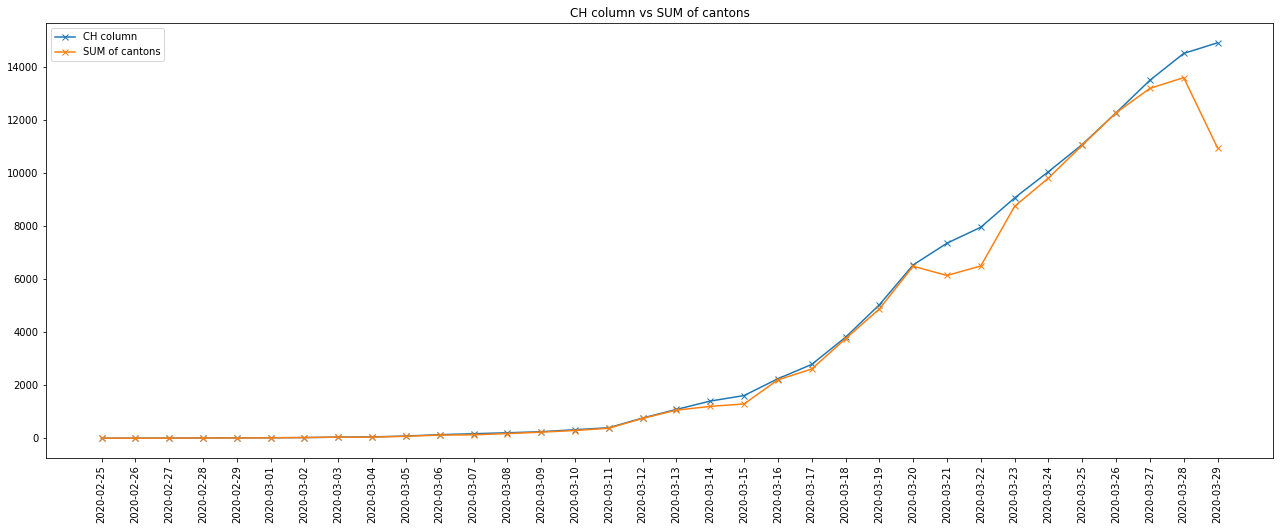

In [6]:
# comparison of `CH` column with the sum of each canton at a given day
canton_sum = covid19_cases.drop('CH', axis=1).sum(axis=1)
ch_col = covid19_cases['CH']

# plot the results
fig = plt.figure(figsize=[22,8])
ax = plt.subplot(111)

ax.plot(ch_col.index, ch_col.values, marker='x', label='CH column')
ax.plot(canton_sum.index, canton_sum.values, marker='x', label='SUM of cantons')

plt.title('CH column vs SUM of cantons')
ax.legend()
plt.xticks(ch_col.index, rotation=90)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

#### observations:
- Eventhough the sum of all canton and the CH column seems to follow the same trend there is a *disparity* between the value. 
- According to the dataset source, each column come from an individual source which can explain why they are note exactly matching.
- the sum of the canton cases goes down at some point which should not be possible as it is cumulative.
- data from the current day seems to not be reliable.

---

#### takeaways:
- If working with the individual canton we would need to clean consecutive day going negative.
- To simplify the problem we will work and consider the data from 'CH' as the truth to work on our prediction.

## Preparing the Data

I will now focus only on the `CH` column from one day earlier than the current day as it looks much cleaner and seems to follow the cumulative number of cases.

Then, I will present several modeling techniques and apply them to the data.


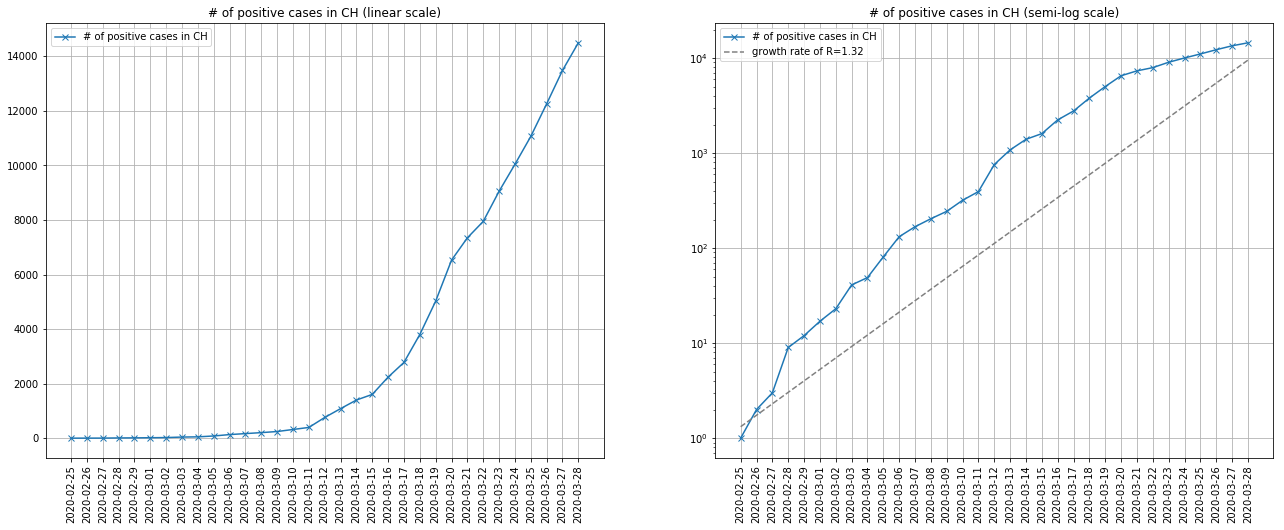

In [7]:
# select the data of interest (CH col from 1 day earlier)
data_ch = covid19_cases['CH'].loc[:date.today() - timedelta(days=1)]

# plot the results
fig = plt.figure(figsize=[22,8])

ax = plt.subplot(121)
ax.plot(data_ch.index, data_ch.values, marker='x', label='# of positive cases in CH')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(data_ch.index, rotation=90)
plt.title('# of positive cases in CH (linear scale)')
plt.grid(True)


ax2 = plt.subplot(122)
ax2.semilogy(data_ch.index, data_ch.values, marker='x', label='# of positive cases in CH')
ax2.semilogy(data_ch.index,[1.32 ** i for i in range(1,len(data_ch.index) + 1)], ls='--', c='grey', label='growth rate of R=1.32')
ax2.legend()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(data_ch.index, rotation=90)
plt.title('# of positive cases in CH (semi-log scale)')
plt.grid(True)
           
plt.show()

#### observations:

- As expected, the trend seems to follow an exponential growth in linear scale.
- Hence a more or less "linear" trend in log scale.


> Observations following an exponential growth and corresponding to fixed numbers, can be model by a Poisson Distribution.

---

To check that the Poisson distribution assumption would be a good fit for our data we can also look at the count of **new cases** per day:

- what distribution the count of new cases per day look like?
- since we have only 1 feature (previous count of cases) do we have a linear relationship with our response (current count of cases)?

In [163]:
# check now the individual new cases
df_ch = data_ch.to_frame()
df_ch['new_cases'] = data_ch.diff().fillna(data_ch)
df_ch.head()

,CH,new_cases
Date,,
2020-02-25,1.0,1.0
2020-02-26,2.0,1.0
2020-02-27,3.0,1.0
2020-02-28,9.0,6.0
2020-02-29,12.0,3.0


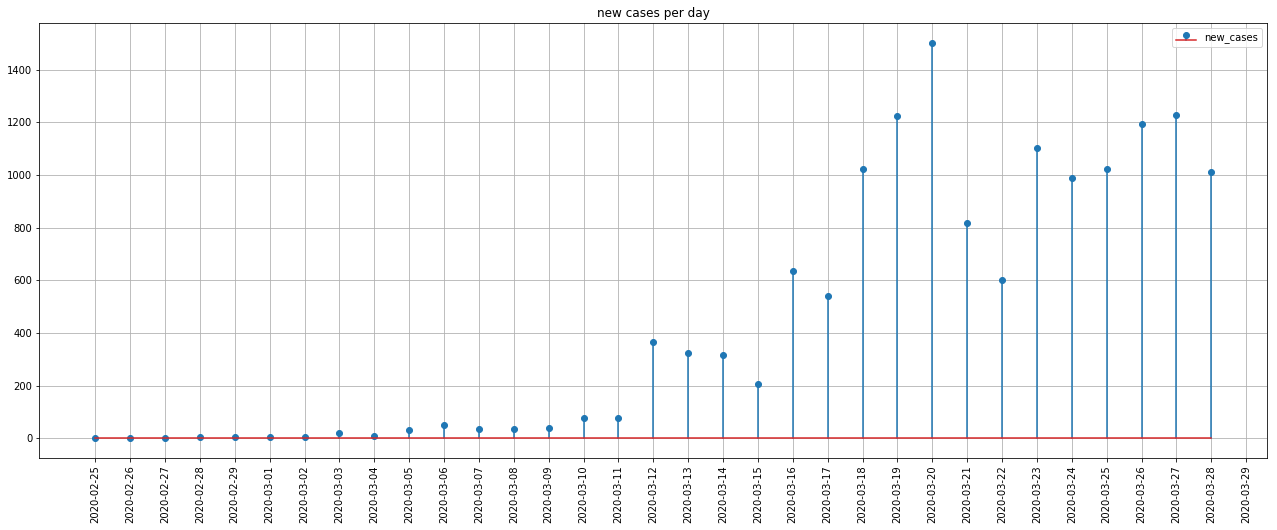

In [168]:
# plot the results
fig = plt.figure(figsize=[22,8])
ax = plt.subplot(111)

ax.stem(df_ch.new_cases.index, df_ch.new_cases.values, label='new_cases')

plt.title('new cases per day')
ax.legend()
plt.xticks(ch_col.index, rotation=90)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid(True)
plt.show()

#### observation:
- We observe a non-gaussian, left skewed distribution of new cases per day.

Let's see now if we can observe the linear relationship between the previous number of cases and the new number.

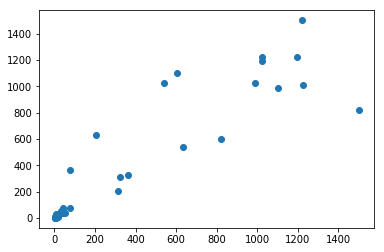

In [201]:
# case 1. the features are the new cases per day.
X = df_ch.new_cases.shift().iloc[1:]
y = df_ch.new_cases.iloc[1:]


plt.scatter(X.values, y.values);

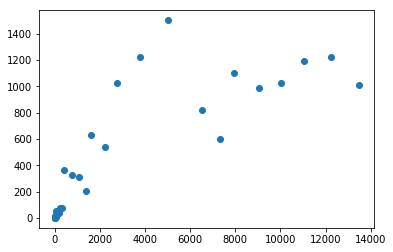

In [208]:
# try with another covariate (the total number of cases on the previous day)
X = df_ch.CH.shift().iloc[1:]
plt.scatter(X.values, y.values);

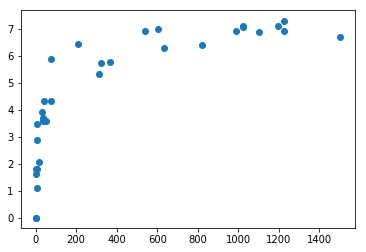

In [210]:
y = df_ch.new_cases.shift(-1).iloc[:-1]
X = df_ch.new_cases.iloc[:-1]

plt.scatter(X.values, np.log(y.values));

## Modeling

A first attempt at modeling the number of cases will be a simple poisson auto-regression based on the case from the previous day.

#### theory behind the model (skippable)

This section set the theoretical grounds for applying a Generalized Linear Model (GLM) on the observed data.

**setup**

For each day $i$, we observe **independent** pairs of random variables $(X_i, Y_i) \in \mathbb{R}^2 \times \mathbb{R}$ where we assume that $Y_i | X_i = x_i \sim Poisson(\lambda_i)$. 

In particular $X_i$ will correspond to a vector with a 1 and the number of cases observed on day $i-1$ and $Y_i$ will correspond to the number of case observed on day $i$.

> <u>Poisson Distribution as an exponential family</u><br>
The probability mass function (pmf) of a Poisson random variable $Y$ w.r.t $\lambda$ can be written as: $p_Y(y) = \frac{\lambda^y  e^{-\lambda}}{y!}$.<br>
Hence, we can rewrite it as a pmf from a *canonical exponential family*: $p_Y(y) = exp[y\ln{\lambda}-\lambda+\ln{y!}]$.<br>
and consider $\theta = \ln{\lambda}$ our canonical parameter with $b(\theta) = \lambda = e^{\theta}$.<br>
note that in this case the dispersion parameter $\phi = 1$.

Since for a poisson random variable $Y$, $\mathbb{E}[Y] = \lambda$. We have the **canonical link $g$** defined in this case as $g(\lambda) = \theta$ and by identification $g$ is the **log link**.

We can now put ourselves in a GLM case by setting $g(\lambda_i) = X_i^T \beta$ and since $g$ is the canonical link we have $\theta_i = X_i^T \beta$ with $\beta \in \mathbb{R}^2$ our vector of parameters to fit on the observations.

Finally, putting ourselves in the GLM case for data following a Poisson Distribution means that we assume to observe $Y_i | X_i = x_i \sim Poisson(e^{X_i^T \beta})$.

**log-likelihood**

Maximizing the log-likelihood of this model will correspond to maximize for each observation the pmf described above with the assumption that $\theta_i = X_i^T \beta$:

$$\max_{\beta} \sum_i Y_i X_i^T \beta - e^{X_i^T \beta}$$

Fortunatly, since we chose $g$ as the canonical link function and our dispersion parameter $\phi$ is 1 we are guaranteed to have **strict concavity** as long as our design matrix has a rank equal to the number of features which in our case is easly achieved since we have very few features (only the previous number of cases) and a lot more of observations.

### preparing the data for the model

I will now prepare the data for the model and then perform the poisson regression using two approaches, the one from sklearn and my own method.

#### data preparation

- For sklearn, the data needs to be splitted into X with the observation (day $i-1$) and y the observed number of case on day $i$.
- For scipy, we will need to add a column of 1 in the design matrix X in order to have an intercept $\beta_0$.

In [114]:
# data for sklearn
X = data_ch.iloc[:-1]
y = data_ch.iloc[1:]

In [115]:
X

Date
2020-02-25        1.0
2020-02-26        2.0
2020-02-27        3.0
2020-02-28        9.0
2020-02-29       12.0
2020-03-01       17.0
2020-03-02       23.0
2020-03-03       41.0
2020-03-04       49.0
2020-03-05       81.0
2020-03-06      132.0
2020-03-07      168.0
2020-03-08      204.0
2020-03-09      244.0
2020-03-10      319.0
2020-03-11      394.0
2020-03-12      759.0
2020-03-13     1083.0
2020-03-14     1398.0
2020-03-15     1605.0
2020-03-16     2239.0
2020-03-17     2778.0
2020-03-18     3801.0
2020-03-19     5024.0
2020-03-20     6526.0
2020-03-21     7345.0
2020-03-22     7947.0
2020-03-23     9051.0
2020-03-24    10040.0
2020-03-25    11063.0
2020-03-26    12257.0
2020-03-27    13483.0
Name: CH, dtype: float64

In [85]:
scaler = MinMaxScaler() 
X_scaled = scaler.fit_transform(X.values.reshape(-1,1), y.values.reshape(-1,1))

In [119]:
X_scaled = np.log(X.values.reshape(-1,1))

In [142]:
# data for scipy
y.iloc[:10]

Date
2020-02-26      2.0
2020-02-27      3.0
2020-02-28      9.0
2020-02-29     12.0
2020-03-01     17.0
2020-03-02     23.0
2020-03-03     41.0
2020-03-04     49.0
2020-03-05     81.0
2020-03-06    132.0
Name: CH, dtype: float64

In [148]:
#### sklearn PoissonRegressor
poisson_lm = PoissonRegressor(alpha=0, max_iter=1000, fit_intercept=True)
poisson_lm.fit(X_scaled[:16,:], y.iloc[:16])

PoissonRegressor(alpha=0, fit_intercept=True, max_iter=1000, tol=0.0001,
                 verbose=0, warm_start=False)

In [149]:
poisson_lm.coef_

array([1.04170131])

In [150]:
poisson_lm.intercept_

0.1474938954609193

In [151]:
y_pred = poisson_lm.predict(X_scaled)

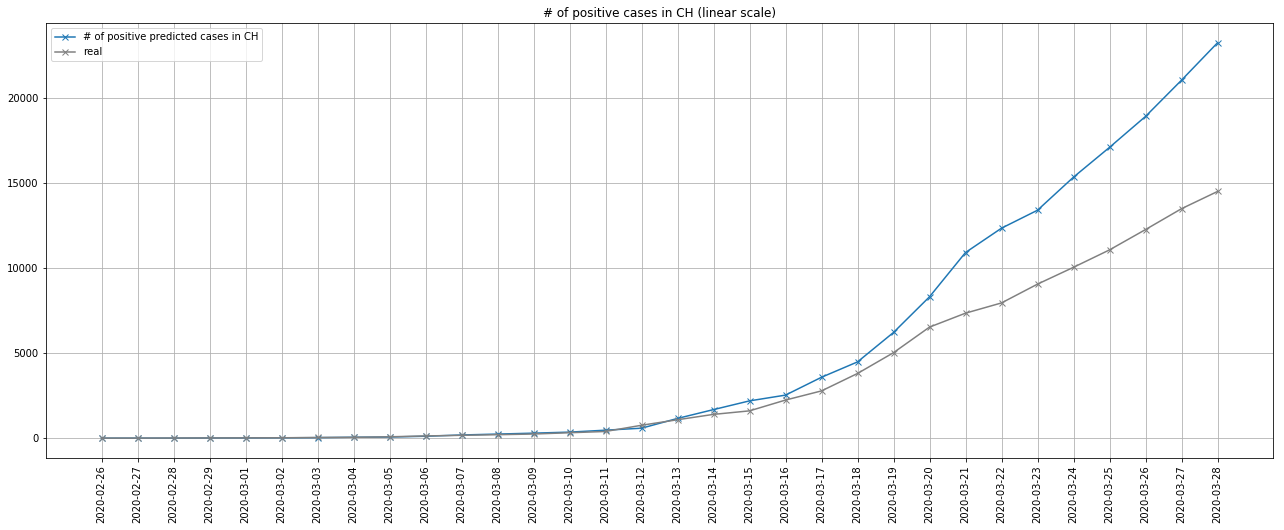

In [152]:
# plot the results
fig = plt.figure(figsize=[22,8])

ax = plt.subplot(111)
ax.plot(y.index, y_pred, marker='x', label='# of positive predicted cases in CH')
ax.plot(y.index,y, marker='x', c='grey', label='real')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(y.index, rotation=90)
plt.title('# of positive cases in CH (linear scale)')
plt.grid(True)
           
plt.show()

In [ ]:
# select the data of interest (CH col from 1 day earlier)
data_ch = covid19_cases['CH'].loc[:date.today() - timedelta(days=1)]

# plot the results
fig = plt.figure(figsize=[22,8])

ax = plt.subplot(121)
ax.plot(data_ch.index, data_ch.values, marker='x', label='# of positive cases in CH')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(data_ch.index, rotation=90)
plt.title('# of positive cases in CH (linear scale)')
plt.grid(True)


ax2 = plt.subplot(122)
ax2.semilogy(data_ch.index, data_ch.values, marker='x', label='# of positive cases in CH')
ax2.semilogy(data_ch.index,[1.32 ** i for i in range(1,len(data_ch.index) + 1)], ls='--', c='grey', label='growth rate of R=1.32')
ax2.legend()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(data_ch.index, rotation=90)
plt.title('# of positive cases in CH (semi-log scale)')
plt.grid(True)
           
plt.show()

In [23]:
#### scipy Home made Poisson Regression
y

Date
2020-02-26        2.0
2020-02-27        3.0
2020-02-28        9.0
2020-02-29       12.0
2020-03-01       17.0
2020-03-02       23.0
2020-03-03       41.0
2020-03-04       49.0
2020-03-05       81.0
2020-03-06      132.0
2020-03-07      168.0
2020-03-08      204.0
2020-03-09      244.0
2020-03-10      319.0
2020-03-11      394.0
2020-03-12      759.0
2020-03-13     1083.0
2020-03-14     1398.0
2020-03-15     1605.0
2020-03-16     2239.0
2020-03-17     2778.0
2020-03-18     3801.0
2020-03-19     5024.0
2020-03-20     6526.0
2020-03-21     7345.0
2020-03-22     7947.0
2020-03-23     9051.0
2020-03-24    10040.0
2020-03-25    11063.0
2020-03-26    12257.0
2020-03-27    13483.0
2020-03-28    14495.0
Name: CH, dtype: float64

In [87]:
len(X_scaled)

32

In [123]:
y_reshaped = y.values.reshape(-1,1)

a = np.array([1.0] * len(X_scaled)).reshape(-1,1)
b = X_scaled
X_reshaped = np.concatenate((a, b), axis=1)

def negloglikelihood(beta):
    """ return the loglikelihood of the Poisson GLM described above.
    
    params:
        - beta: vector of weight of shape 2,1
    """
    
    t = np.matmul(X_reshaped, beta)
    return -np.sum(y_reshaped * t - np.exp(t))
    

In [126]:
- negloglikelihood(np.array([[0.86],[0.91]]))

898472.830619683

In [69]:
beta_0 = np.array([[0],[0]])
loglikelihood(beta_0)

-32.0

In [124]:
beta_0 = np.array([[0],[0]])
minimize(negloglikelihood, beta_0)

      fun: -25817940.234945662
 hess_inv: array([[ 1.57594860e-06, -2.17548914e-07],
       [-2.17548914e-07,  3.64939448e-08]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 12
     njev: 21
   status: 0
  success: True
        x: array([ 8.16579019e+00, -2.69838255e-08])

In [107]:
np.exp(700)

1.0142320547350045e+304

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.19447532, 0.25585576, 0.32224364, 0.3899795 , 0.46414843,
        0.54304484, 0.62656653, 0.71596064, 0.81097583, 0.90832388,
        1.        , 0.90832388, 0.81097583, 0.71596064, 0.62656653,
        0.54304484, 0.46414843, 0.3899795 , 0.32224364, 0.25585576,
        0.19447532]),
 <matplotlib.lines.Line2D at 0x1a29c73470>)

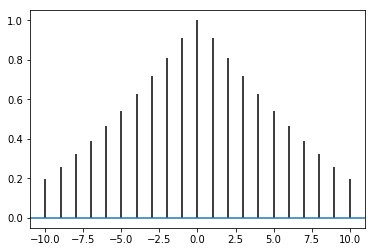

In [108]:
plt.acorr(ch_col)

In [113]:
# logistic regression to find the percentage of population touched ? easier
total_pop = 8.57e+6
X.apply(lambda row: row/total_pop)

Date
2020-02-25    1.166861e-07
2020-02-26    2.333722e-07
2020-02-27    3.500583e-07
2020-02-28    1.050175e-06
2020-02-29    1.400233e-06
2020-03-01    1.983664e-06
2020-03-02    2.683781e-06
2020-03-03    4.784131e-06
2020-03-04    5.717620e-06
2020-03-05    9.451575e-06
2020-03-06    1.540257e-05
2020-03-07    1.960327e-05
2020-03-08    2.380397e-05
2020-03-09    2.847141e-05
2020-03-10    3.722287e-05
2020-03-11    4.597433e-05
2020-03-12    8.856476e-05
2020-03-13    1.263711e-04
2020-03-14    1.631272e-04
2020-03-15    1.872812e-04
2020-03-16    2.612602e-04
2020-03-17    3.241540e-04
2020-03-18    4.435239e-04
2020-03-19    5.862310e-04
2020-03-20    7.614936e-04
2020-03-21    8.570595e-04
2020-03-22    9.273046e-04
2020-03-23    1.056126e-03
2020-03-24    1.171529e-03
2020-03-25    1.290898e-03
2020-03-26    1.430222e-03
2020-03-27    1.573279e-03
Name: CH, dtype: float64